In [1]:
'''Trains a memory network on the bAbI dataset.
References:
- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698
- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895
Reaches 98.6% accuracy on task 'single_supporting_fact_10k' after 120 epochs.
Time per epoch: 3s on CPU (core i7).
'''

'Trains a memory network on the bAbI dataset.\nReferences:\n- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,\n  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",\n  http://arxiv.org/abs/1502.05698\n- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,\n  "End-To-End Memory Networks",\n  http://arxiv.org/abs/1503.08895\nReaches 98.6% accuracy on task \'single_supporting_fact_10k\' after 120 epochs.\nTime per epoch: 3s on CPU (core i7).\n'

In [2]:
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


In [4]:
def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data

In [5]:
def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

In [6]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

In [7]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
tar = tarfile.open(path)

In [8]:
challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',

    'two_arg_relations_10k': 'tasks_1-20_v1-2/en-10k/qa4_two-arg-relations_{}.txt',

    'qa6_yes_no_ques_10k': 'tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_{}.txt',
}
challenge_type = 'qa6_yes_no_ques_10k'
challenge = challenges[challenge_type]

In [9]:
print('Extracting stories for the challenge:', challenge_type)
train_stories = get_stories(tar.extractfile(challenge.format('train')))
test_stories = get_stories(tar.extractfile(challenge.format('test')))


Extracting stories for the challenge: qa6_yes_no_ques_10k


C:\ProgramData\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [10]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)


In [11]:
# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[1])
print('-')
print('Vectorizing the word sequences...')

-
Vocab size: 38 unique words
Story max length: 156 words
Query max length: 6 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'went', 'back', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.'], ['Is', 'Daniel', 'in', 'the', 'bathroom', '?'], 'no')
-
Vectorizing the word sequences...


In [12]:
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)

In [13]:
print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')

-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 156)
inputs_test shape: (1000, 156)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 6)
queries_test shape: (1000, 6)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 38)
answers_test shape: (1000, 38)
-
Compiling...


In [14]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

In [15]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

In [16]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

In [17]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [18]:
# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [19]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [20]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [21]:
# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer = LSTM(32)(answer)  # (samples, 32)

In [22]:
# one regularization layer -- more would probably be needed.
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
# train
history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=60,
          validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/60
10000/10000 [==============================] - 8s 805us/step - loss: 0.8980 - acc: 0.4852 - val_loss: 0.6992 - val_acc: 0.4970
Epoch 2/60
10000/10000 [==============================] - 5s 465us/step - loss: 0.7027 - acc: 0.4946 - val_loss: 0.7019 - val_acc: 0.4970
Epoch 3/60
10000/10000 [==============================] - 5s 467us/step - loss: 0.6956 - acc: 0.5071 - val_loss: 0.6942 - val_acc: 0.4970
Epoch 4/60
10000/10000 [==============================] - 5s 474us/step - loss: 0.6954 - acc: 0.4972 - val_loss: 0.6933 - val_acc: 0.5030
Epoch 5/60
10000/10000 [==============================] - 5s 467us/step - loss: 0.6945 - acc: 0.4976 - val_loss: 0.6934 - val_acc: 0.4650
Epoch 6/60
10000/10000 [==============================] - 5s 465us/step - loss: 0.6941 - acc: 0.5003 - val_loss: 0.6942 - val_acc: 0.5030
Epoch 7/60
10000/10000 [==============================] - 5s 465us/step - loss: 0.6939 - acc: 0.4996 - val_loss: 0.6942 - v

10000/10000 [==============================] - 5s 465us/step - loss: 0.2751 - acc: 0.8822 - val_loss: 0.4142 - val_acc: 0.8190
Epoch 60/60
10000/10000 [==============================] - 5s 468us/step - loss: 0.2753 - acc: 0.8811 - val_loss: 0.3965 - val_acc: 0.8300


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


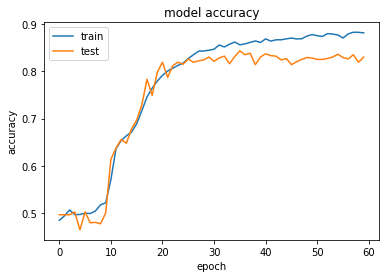

In [25]:
%matplotlib inline  

# list all data in history
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [26]:
model_path1 = r'model6.h5'
model.save(model_path1)
#model save as pickle file
# model load again
# write story answer question in the format in a text file

model.load_weights(model_path1)
pred_results = model.predict(([inputs_test, queries_test]))
# Display a selected test story

In [27]:
n = np.random.randint(0,1000)
story_list = test_stories[n][0]
story =' '.join(word for word in story_list)
print("Story is:",story)

question_list = test_stories[n][1]
ques =' '.join(word for word in question_list)
print("Question is: ",ques)

ans = test_stories[n][2]
print("Actual answer is: ", ans)


Story is: John moved to the office . Mary went back to the hallway . Daniel went back to the bedroom . John grabbed the milk there . Sandra travelled to the kitchen . John discarded the milk . Mary moved to the office . John picked up the milk there . John travelled to the bedroom . Mary journeyed to the bedroom .
Question is:  Is John in the kitchen ?
Actual answer is:  no


In [28]:
#Generate prediction from model

val_max = np.argmax(pred_results[n])

for key, val in word_idx.items():
    if val == val_max:
        k = key

print("Machine answer is: ", k)
print("I am ", pred_results[n][val_max], "certain of it")

## Read my own file

# f = open(r"C:\Users\priya\Documents\my_dl\qachatbot\my_test_q2.txt", "r")
# print(f.readlines())
# data = parse_stories(f.readlines(), only_supporting=False)
# print(data)
# extra_stories = get_stories(f, only_supporting=False, max_length=None)
#
# print(extra_stories)

Machine answer is:  no
I am  0.9973923 certain of it
